In [1]:
import sys
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import norm
from tqdm.notebook import trange
 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import initializers, optimizers, layers
from tensorflow.keras.layers import Dense, Input, Concatenate, Subtract, Multiply, Lambda, Add, Dot
from tensorflow.keras.models import Model, load_model
import tensorflow.keras.backend as K
 
print('Python version: ', sys.version)
print('Tensorflow version: ', tf.__version__)
print('Keras version: ', keras.__version__)

Python version:  3.7.11 (default, Jul  3 2021, 18:01:19) 
[GCC 7.5.0]
Tensorflow version:  2.6.0
Keras version:  2.6.0


In [2]:
########## ------------------------------
### Parameter initialization
T = 1
N = 32
delta_t = T/N
strike = 70.0
r = 0.05
N_assets = 20

In [3]:
X_0 = np.around(np.random.uniform(low=40.0, high=50.0, size=(N_assets,1)),0)
# X_0

In [4]:
mu = np.around(np.random.uniform(low=0.0, high=0.10, size=(N_assets, 1)),2) # can be $r - dividends$
# mu

In [5]:
sigma = np.around(np.random.uniform(low=-0.3, high=0.3, size=(N_assets,N_assets)), 2)
# sigma

In [6]:
volvec = (norm(sigma, axis=0) ** 2).reshape((N_assets,1))
# volvec

In [7]:
tilde_mu = mu - 0.5 * volvec
# tilde_mu

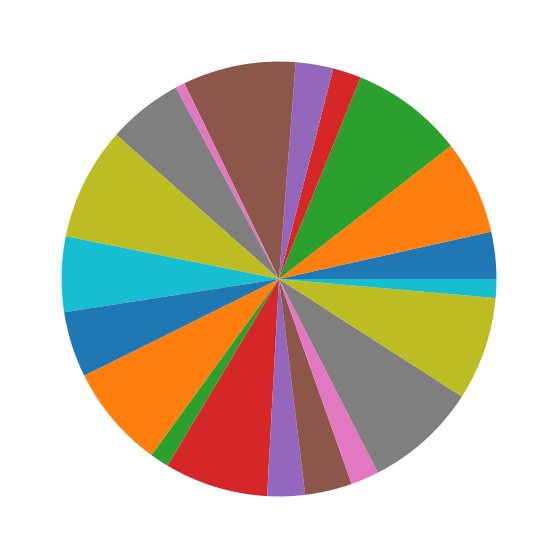

In [8]:
weights = np.around(mu / (norm(sigma, axis=0)).reshape((N_assets,1)),2)
weights = weights / np.sum(weights)
 
plt.figure(figsize=(18, 10)) 
plt.pie(weights.reshape((N_assets)))
plt.show()

In [ ]:
# X_0 = np.array([50.0])
# strike = 70.0
# mu = np.array([0.05])
# sigma = np.array([[0.25]])
# N = 64

# print(X_0)
# print(mu)
# print(sigma)
# print(weights)
# plt.hist(weights)

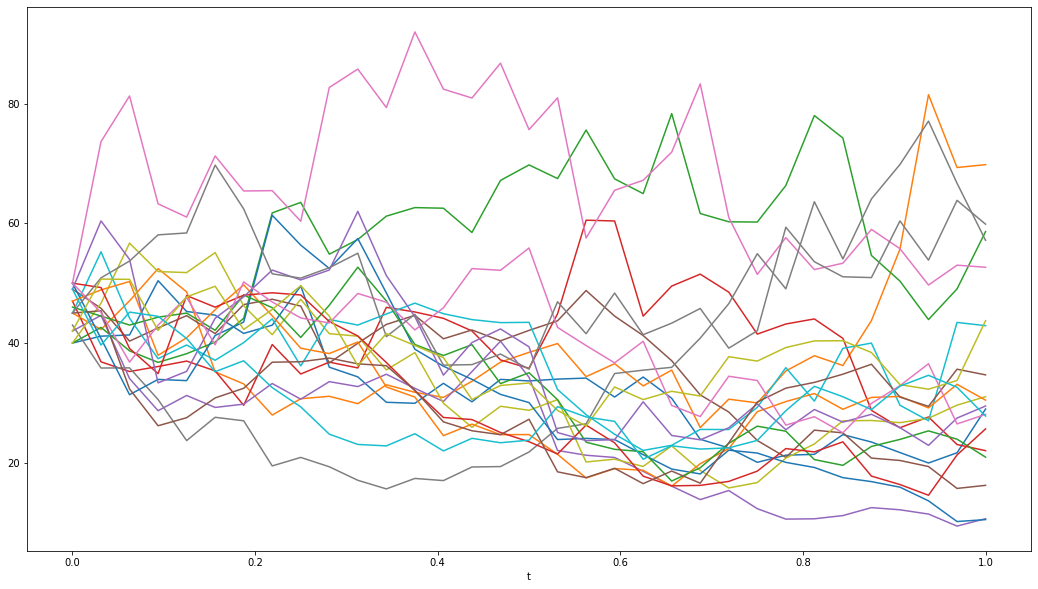

39.12529483334016


0.0

In [9]:
M = np.concatenate((np.zeros((N_assets,1)), np.random.normal(0, np.sqrt(delta_t), (N_assets,N))), axis=1)
M = np.cumsum(M, axis=1)
M = np.dot(np.transpose(sigma), M)
 
M = np.diff(M, axis=1)
M = M + tilde_mu * delta_t
 
M = np.concatenate((np.zeros((N_assets,1)),M), axis=1)
M = np.cumsum(M, axis=1)
 
M = np.exp(M)
for i in range(N_assets):
    M[i,:] = M[i,:] * X_0[i]
    
t = np.linspace(0, T, N+1) 
plt.figure(figsize=(18, 10)) 
plt.plot(t, np.transpose(M))
plt.xlabel("t")
plt.show()
 
print(np.sum(np.multiply(weights, np.sum(M * delta_t, axis=1).reshape((N_assets,1)) / T)))
np.exp(-r*T) * 100 * np.clip(np.sum(np.multiply(weights, np.sum(M * delta_t, axis=1).reshape((N_assets,1)) / T)) - strike, 0, None)

In [ ]:
def progressbar(it, prefix="", size=60, file=sys.stdout):
    count = len(it)
    def show(j):
        x = int(size*j/count)
        file.write("%s[%s%s] %i/%i\r" % (prefix, "#"*x, "."*(size-x), j, count))
        file.flush()        
    show(0)
    for i, item in enumerate(it):
        yield item
        show(i+1)
    file.write("\n")
    file.flush()

In [10]:
N_sample = 5000
outcomes = []
 
start_time = time.time()
 
for i in trange(N_sample):
# for i in progressbar(range(N_sample), "Computing: ", 60):
    M = np.concatenate((np.zeros((N_assets,1)), np.random.normal(0, np.sqrt(delta_t), (N_assets,N))), axis=1)
    M = np.cumsum(M, axis=1)
    M = np.dot(np.transpose(sigma), M)
 
    M = np.diff(M, axis=1)
    M = M + tilde_mu * delta_t
 
    M = np.concatenate((np.zeros((N_assets,1)),M), axis=1)
    M = np.cumsum(M, axis=1)
 
    M = np.exp(M)
    for j in range(N_assets):
        M[j,:] = M[j,:] * X_0[j]
        
    outcomes = outcomes + [np.exp(-r*T) * 100 * np.clip(np.sum(np.multiply(weights, np.sum(M * delta_t, axis=1).reshape((N_assets,1)) / T)) - strike, 0, None)]
 
elapsed_time = time.time() - start_time
 
mean_mc = np.mean(outcomes)
std_mc = np.std(outcomes)
stderr_mc = std_mc / np.sqrt(N_sample)
 
print("elapsed time: ", time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))
 
print("Mean (MC): ", np.around(mean_mc, 4))
print("Standard error (MC): ", np.around(stderr_mc, 4), " (", np.around(stderr_mc / mean_mc * 100, 2), "% )")

  0%|          | 0/5000 [00:00<?, ?it/s]

elapsed time:  00:00:01
Mean (MC):  11.2173
Standard error (MC):  1.6067  ( 14.32 % )


In [ ]:
N_sample = 20000
outcomes = []

start_time = time.time()

for i in trange(N_sample):
# for i in progressbar(range(N_sample), "Computing: ", 60):
    M = np.concatenate((np.zeros((N_assets,1)), np.random.normal(0, np.sqrt(delta_t), (N_assets,N))), axis=1)
    M = np.cumsum(M, axis=1)
    M = np.dot(np.transpose(sigma), M)

    M = np.diff(M, axis=1)
    M = M + tilde_mu * delta_t

    M = np.concatenate((np.zeros((N_assets,1)),M), axis=1)
    M = np.cumsum(M, axis=1)

    M = np.exp(M)
    for j in range(N_assets):
        M[j,:] = M[j,:] * X_0[j]
        
    outcomes = outcomes + [np.exp(-r*T) * 100 * np.clip(np.sum(np.multiply(weights, np.sum(M * delta_t, axis=1).reshape((N_assets,1)) / T)) - strike, 0, None)]

elapsed_time = time.time() - start_time

mean_mc = np.mean(outcomes)
std_mc = np.std(outcomes)
stderr_mc = std_mc / np.sqrt(N_sample)

print("elapsed time: ", time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

print("Mean (MC): ", np.around(mean_mc, 4))
print("Standard error (MC): ", np.around(stderr_mc, 4), " (", np.around(stderr_mc / mean_mc * 100, 2), "% )")

In [ ]:
N_sample = 100000
outcomes = []

start_time = time.time()

for i in trange(N_sample):
# for i in progressbar(range(N_sample), "Computing: ", 60):
    M = np.concatenate((np.zeros((N_assets,1)), np.random.normal(0, np.sqrt(delta_t), (N_assets,N))), axis=1)
    M = np.cumsum(M, axis=1)
    M = np.dot(np.transpose(sigma), M)

    M = np.diff(M, axis=1)
    M = M + tilde_mu * delta_t

    M = np.concatenate((np.zeros((N_assets,1)),M), axis=1)
    M = np.cumsum(M, axis=1)

    M = np.exp(M)
    for j in range(N_assets):
        M[j,:] = M[j,:] * X_0[j]
        
    outcomes = outcomes + [np.exp(-r*T) * 100 * np.clip(np.sum(np.multiply(weights, np.sum(M * delta_t, axis=1).reshape((N_assets,1)) / T)) - strike, 0, None)]

elapsed_time = time.time() - start_time

mean_mc = np.mean(outcomes)
std_mc = np.std(outcomes)
stderr_mc = std_mc / np.sqrt(N_sample)

print("elapsed time: ", time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

print("Mean (MC): ", np.around(mean_mc, 4))
print("Standard error (MC): ", np.around(stderr_mc, 4), " (", np.around(stderr_mc / mean_mc * 100, 2), "% )")

In [11]:
########## ------------------------------
### Defining the feed forward neural network
 
R = 2*10**5
learnrate = 0.01    # learning rate in SGD
 
layers = []
 
layer = Dense(20, activation="tanh", trainable=True, 
              kernel_initializer=initializers.RandomNormal(0.0, 0.1), 
              bias_initializer=initializers.RandomNormal(0.0, 0.1), 
              name=str(0))
 
layers = layers + [layer]
 
layer = Dense(N_assets, activation="linear", trainable=True, 
              kernel_initializer=initializers.RandomNormal(0.0, 0.1), 
              bias_initializer=initializers.RandomNormal(0.0, 0.1), 
              name=str(1))
 
layers = layers + [layer]

In [12]:
########## ------------------------------
### Defining the training data
 
Ktrain = R
xtrain = ([0*np.ones((Ktrain,1))] + # t_0
          [delta_t*np.ones((Ktrain,N_assets))] + # time increment
          [0*np.ones((Ktrain,N_assets))] + # M_0
          [np.tile(X_0.reshape((N_assets)), (Ktrain, 1))] + # X_0
          [np.tile(weights.reshape((N_assets))/T, (Ktrain, 1))] + # wght
          [0*np.ones((Ktrain,N_assets))] + # initial value of the payoff
          [0*np.ones((Ktrain,N_assets))] + # initial value of the first part of the stoch exp
          [0*np.ones((Ktrain,N_assets))] + # initial value of the second part of the stoch exp
          [np.random.normal(0,np.sqrt(delta_t),(Ktrain,N_assets)) for i in range(N)]) # Brownian increments
 
ytrain = np.zeros((Ktrain, 1))

In [13]:
### Training loop
 
t_0 = Input(shape=(1, ))
d_t = Input(shape=(N_assets, ))
 
M_0 = Input(shape=(N_assets, ))
X_start = Input(shape=(N_assets, ))
 
wght = Input(shape=(N_assets, ))
 
c_0 = Input(shape=(N_assets, ))
c_1 = Input(shape=(N_assets, ))
c_2 = Input(shape=(N_assets, ))
 
inputs = [t_0]+[d_t]+[M_0]+[X_start]+[wght]+[c_0]+[c_1]+[c_2]
 
t_current = t_0
M_current = M_0
X_current = X_start
 
for j in range(N):
    
    strategy = t_current
    strategy = layers[0](strategy)
    strategy = layers[1](strategy)
    
    incr_M = Input(shape=(N_assets, ))
    inputs = inputs + [incr_M]
    
    M_current = Add()([M_current, incr_M])
    helper_0 = tf.transpose(K.dot(K.constant(np.transpose(sigma)), tf.transpose(M_current)))
    helper_1 = Lambda(lambda x: tilde_mu.reshape((N_assets)) * x)(t_current)
    helper_2 = Add()([helper_1, helper_0])
    helper_3 = Lambda(lambda x: K.exp(x))(helper_2)
    helper_4 = Multiply()([helper_3, d_t])
    helper_5 = Multiply()([X_start, helper_4])
    helper_6 = Multiply()([wght, helper_5])
    c_0 = Add()([c_0, helper_6])
    
    helper_e1 = Multiply()([strategy, incr_M])
    c_1 = Add()([c_1, helper_e1])
    
    helper_e2 = Multiply()([strategy, strategy])
    helper_e3 = Multiply()([helper_e2, d_t])
    c_2 = Add()([c_2, helper_e3])
    
    t_current = Lambda(lambda x: x + delta_t)(t_current)
    
helper_e4 = Lambda(lambda x: -0.5 * K.sum(x, axis=1))(c_1)
helper_e5 = Lambda(lambda x: 0.25 * K.sum(x, axis=1))(c_2)
 
helper_e6 = Add()([helper_e4, helper_e5])
helper_e7 = Lambda(lambda x: K.exp(x))(helper_e6)
 
c_0 = Lambda(lambda x: K.sum(x, axis=1))(c_0)
c_0 = Lambda(lambda x: K.relu(x - strike))(c_0)
 
c_0 = Multiply()([c_0, helper_e7])
 
outputs = [c_0]

In [14]:
def custom_loss(y_true,y_pred):
    z = K.mean(K.square(y_pred))
    return z
 
adam = optimizers.Adam(learning_rate=learnrate)
 
model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=adam,loss=custom_loss)

In [31]:
# model.summary()
K.set_value(model.optimizer.learning_rate, 0.0001)

In [46]:
model.fit(x=xtrain, y=ytrain, verbose=1, epochs=25, batch_size=1000, shuffle = True)

Epoch 1/25
200/200 [==============================] - 6s 30ms/step - loss: 0.1476
Epoch 2/25
200/200 [==============================] - 6s 30ms/step - loss: 0.1459
Epoch 3/25
200/200 [==============================] - 6s 30ms/step - loss: 0.1445
Epoch 4/25
200/200 [==============================] - 6s 30ms/step - loss: 0.1434
Epoch 5/25
200/200 [==============================] - 6s 30ms/step - loss: 0.1421
Epoch 6/25
200/200 [==============================] - 6s 30ms/step - loss: 0.1410
Epoch 7/25
200/200 [==============================] - 6s 30ms/step - loss: 0.1396
Epoch 8/25
200/200 [==============================] - 6s 30ms/step - loss: 0.1392
Epoch 9/25
200/200 [==============================] - 6s 30ms/step - loss: 0.1376
Epoch 10/25
200/200 [==============================] - 6s 30ms/step - loss: 0.1365
Epoch 11/25
200/200 [==============================] - 6s 30ms/step - loss: 0.1354
Epoch 12/25
200/200 [==============================] - 6s 30ms/step - loss: 0.1345
Epoch 13/25
2

In [ ]:
# model.summary()

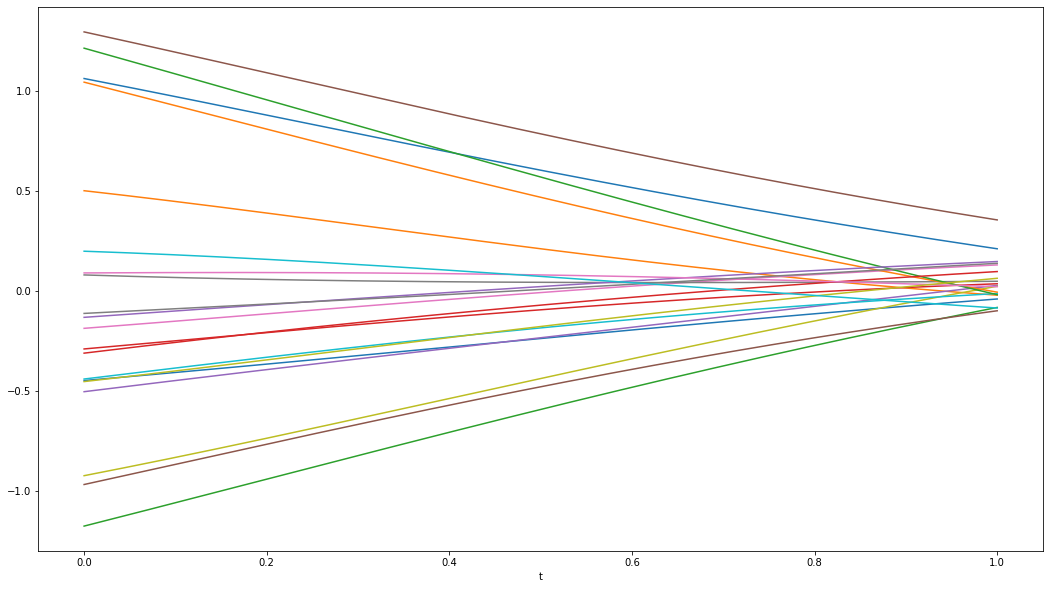

In [47]:
N = 252
delta_t = T/N
 
model_test = keras.Sequential()
model_test.add(Dense(20, activation="tanh", name="layer1", input_shape=(1, )))
model_test.add(Dense(N_assets, activation="linear", name="layer2"))
 
model_test.build()
 
model_test.layers[0].set_weights(model.layers[27].get_weights())
model_test.layers[1].set_weights(model.layers[38].get_weights())
 
t = np.linspace(0, T, N+1)
learnedstrat = model_test.predict(t)
 
plt.figure(figsize=(18, 10))
plt.plot(t, learnedstrat)
plt.xlabel("t")
plt.show()

In [ ]:
M_random = np.concatenate((np.zeros((N_assets,1)), np.random.normal(0, np.sqrt(delta_t), (N_assets,N))), axis=1)

M_MC = np.cumsum(M_random, axis=1)
M_MC = np.dot(np.transpose(sigma), M_MC)

M_MC = np.diff(M_MC, axis=1)
M_MC = M_MC + tilde_mu * delta_t

M_MC = np.concatenate((np.zeros((N_assets,1)),M_MC), axis=1)
M_MC = np.cumsum(M_MC, axis=1)

M_MC = np.exp(M_MC)
for j in range(N_assets):
    M_MC[j,:] = M_MC[j,:] * X_0[j]
        
###

M_0 = M_random + np.concatenate((np.zeros((N_assets,1)), np.transpose(learnedstrat[0:N,:]) * delta_t), axis=1)
M_0 = np.cumsum(M_0, axis=1)
M = np.dot(np.transpose(sigma), M_0)

M = np.diff(M, axis=1)
M = M + tilde_mu * delta_t

M = np.concatenate((np.zeros((N_assets,1)), M), axis=1)
M = np.cumsum(M, axis=1)

M = np.exp(M)
for j in range(N_assets):
    M[j,:] = M[j,:] * X_0[j]

plt.figure(figsize=(18, 10)) 
plt.plot(t, np.transpose(M), color = "blue", label="with drift adjustment")
plt.plot(t, np.transpose(M_MC), color = "red", label="without drift adjustment")
plt.xlabel("t")
# plt.legend(loc="upper left")
plt.show()

In [48]:
N_reps = 100
N_sample = 5000
 
start_time = time.time()
 
means_MC = []
means_IS = []
 
stderr_MC = []
stderr_IS = []
 
varratio = []
 
for k in trange(N_reps):
# for k in progressbar(range(N_reps), "Computing: ", 60):
    outcomes_MC = []
    outcomes_IS = []
    
    # for i in trange(N_sample):
    # for i in progressbar(range(N_sample), "Computing: ", 60):
    for i in range(N_sample):
        
        M_random = np.concatenate((np.zeros((N_assets,1)), np.random.normal(0, np.sqrt(delta_t), (N_assets,N))), axis=1)
    
        ##########
    
        M_MC = np.cumsum(M_random, axis=1)
        M_MC = np.dot(np.transpose(sigma), M_MC)
 
        M_MC = np.diff(M_MC, axis=1)
        M_MC = M_MC + tilde_mu * delta_t
 
        M_MC = np.concatenate((np.zeros((N_assets,1)),M_MC), axis=1)
        M_MC = np.cumsum(M_MC, axis=1)
 
        M_MC = np.exp(M_MC)
        for j in range(N_assets):
            M_MC[j,:] = M_MC[j,:] * X_0[j]
        
        ot_MC = np.clip(np.sum(np.multiply(weights, np.sum(M_MC * delta_t, axis=1).reshape((N_assets,1)) / T)) - strike, 0, None)
        
        outcomes_MC = outcomes_MC + [np.exp(-r*T) * 100 * ot_MC]
 
        ##########
    
        M_0 = M_random + np.concatenate((np.zeros((N_assets,1)), np.transpose(learnedstrat[0:N,:]) * delta_t), axis=1)
    
        M_0 = np.cumsum(M_0, axis=1)
        M = np.dot(np.transpose(sigma), M_0)
 
        M = np.diff(M, axis=1)
        M = M + tilde_mu * delta_t
    
        M = np.concatenate((np.zeros((N_assets,1)), M), axis=1)
        M = np.cumsum(M, axis=1)
 
        M = np.exp(M)
        for j in range(N_assets):
            M[j,:] = M[j,:] * X_0[j]
        
        M_0 = np.diff(M_0, axis=1)
    
        adj1 = np.sum(np.sum(np.multiply(np.transpose(learnedstrat[0:N,:]), M_0), axis=1), axis=0)
        adj2 = np.sum(np.sum(np.multiply(np.transpose(learnedstrat[0:N,:]), np.transpose(learnedstrat[0:N,:])) * delta_t, axis=1), axis=0)
    
        ot_IS = np.clip(np.sum(np.multiply(weights, np.sum(M * delta_t, axis=1).reshape((N_assets,1)) / T)) - strike, 0, None)
        
        outcomes_IS = outcomes_IS + [np.exp(-r*T) * 100 * ot_IS * np.exp(-1 * adj1 + 0.5 * adj2)]
    
    means_MC = means_MC + [np.mean(outcomes_MC)]
    means_IS = means_IS + [np.mean(outcomes_IS)]
    
    stderr_MC = stderr_MC + [np.std(outcomes_MC) / np.sqrt(N_sample)]
    stderr_IS = stderr_IS + [np.std(outcomes_IS) / np.sqrt(N_sample)]
    
    varratio = varratio + [np.var(outcomes_MC) / np.var(outcomes_IS)]
    
    if (k+1) % 10 == 0:
        elapsed_time = time.time() - start_time
        print("elapsed time: ", time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))
    
elapsed_time = time.time() - start_time
print("total elapsed time: ", time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

  0%|          | 0/100 [00:00<?, ?it/s]

elapsed time:  00:00:57
elapsed time:  00:01:55
elapsed time:  00:02:53
elapsed time:  00:03:50
elapsed time:  00:04:48
elapsed time:  00:05:48
elapsed time:  00:06:46
elapsed time:  00:07:44
elapsed time:  00:08:43
elapsed time:  00:09:41
total elapsed time:  00:09:41


In [49]:
print("Mean (MC): ", np.around(np.mean(means_MC), 4))
print("Mean (IS): ", np.around(np.mean(means_IS), 4))
print("Standard error (MC): ", np.around(np.mean(stderr_MC), 4), " (", np.around(np.mean(stderr_MC) / np.mean(means_MC) * 100, 2), "% )")
print("Standard error (IS): ", np.around(np.mean(stderr_IS), 4), " (", np.around(np.mean(stderr_IS) / np.mean(means_IS) * 100, 2), "% )")
print("Variance ratio: ", np.around(np.mean(varratio)))

Mean (MC):  9.995
Mean (IS):  9.7852
Standard error (MC):  1.5337  ( 15.34 % )
Standard error (IS):  0.3864  ( 3.95 % )
Variance ratio:  17.0


mean MC estimate:   9.995
mean IS estimate:  9.7852


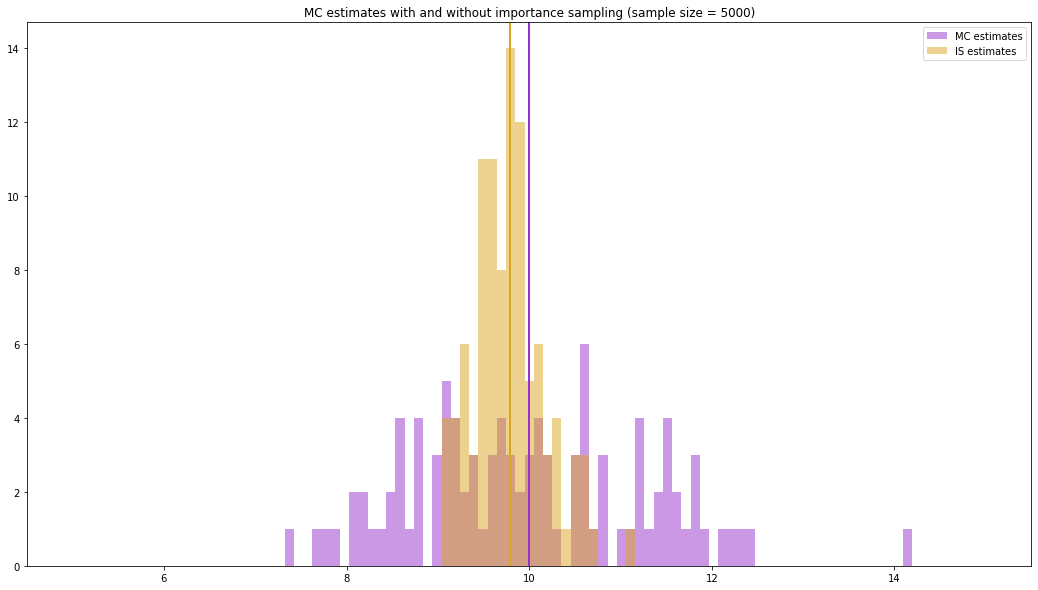

In [53]:
print("mean MC estimate:  ", np.around(np.mean(means_MC), 4))
print("mean IS estimate: ", np.around(np.mean(means_IS), 4))
 
bins = np.linspace(5.00, 15.00, 100)
 
plt.figure(figsize=(18, 10)) 
plt.hist(means_MC, bins, color="darkorchid", alpha=0.5, label="MC estimates")
plt.hist(means_IS, bins, color="goldenrod", alpha=0.5, label="IS estimates")
plt.axvline(np.mean(means_MC), color="darkorchid", linewidth=2)
plt.axvline(np.mean(means_IS), color="goldenrod", linewidth=2)
plt.title("MC estimates with and without importance sampling (sample size = 5000)")
plt.legend(loc="upper right")
plt.show()

mean MC estimate standard error:   1.5337
mean IS estimate standard error:  0.3864


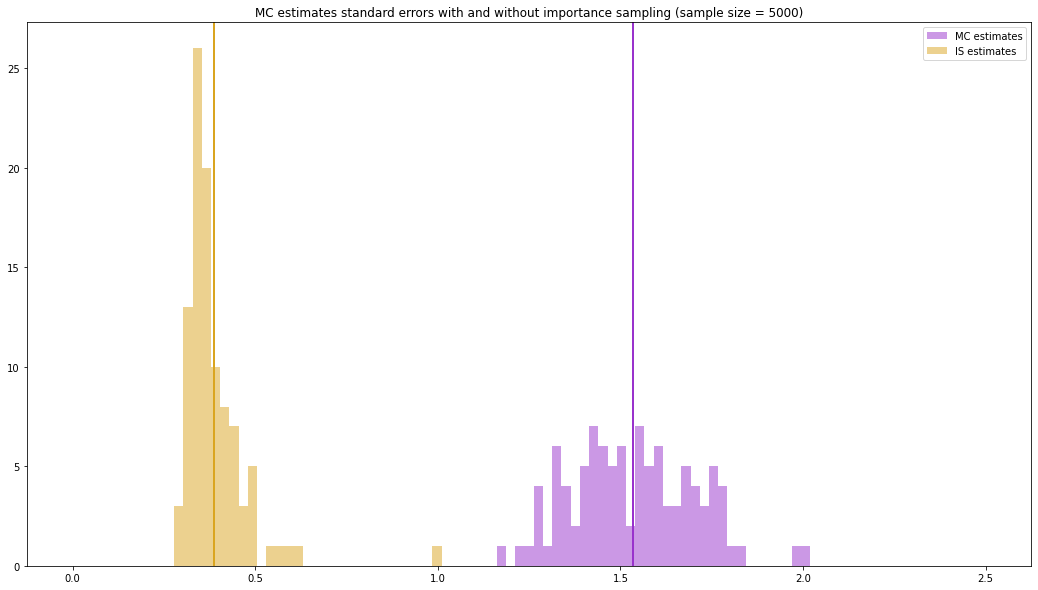

In [54]:
print("mean MC estimate standard error:  ", np.around(np.mean(stderr_MC), 4))
print("mean IS estimate standard error: ", np.around(np.mean(stderr_IS), 4))
 
bins = np.linspace(0.00, 2.50, 100)
 
plt.figure(figsize=(18, 10)) 
plt.hist(stderr_MC, bins, color="darkorchid", alpha=0.5, label="MC estimates")
plt.hist(stderr_IS, bins, color="goldenrod", alpha=0.5, label="IS estimates")
plt.axvline(np.mean(stderr_MC), color="darkorchid", linewidth=2)
plt.axvline(np.mean(stderr_IS), color="goldenrod", linewidth=2)
plt.title("MC estimates standard errors with and without importance sampling (sample size = 5000)")
plt.legend(loc="upper right")
plt.show()

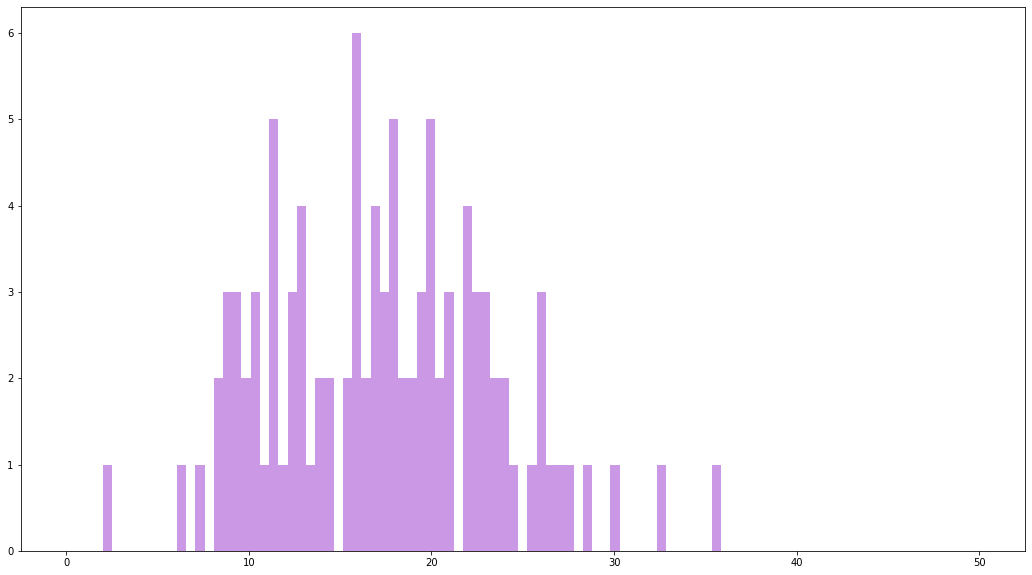

In [55]:
bins = np.linspace(0.00, 50.00, 100)
 
plt.figure(figsize=(18, 10)) 
plt.hist(varratio, bins, color="darkorchid", alpha=0.5)
plt.show()

In [59]:
import pandas as pd
 
data = {'mean MC': means_MC,
        'mean IS': means_IS,
        'stderr MC': stderr_MC,
        'stderr IS': stderr_IS, 
        'varratio': varratio}
 
df = pd.DataFrame(data, columns = ['mean MC','mean IS', 'stderr MC', 'stderr IS', 'varratio'])
df = df.sort_values(by=['varratio'])
 
print(df.tail(50))

      mean MC    mean IS  stderr MC  stderr IS   varratio
95  10.498198  10.165732   1.676592   0.403797  17.239680
67   8.381579   9.509487   1.362269   0.327901  17.259991
51   9.113856   9.366965   1.420680   0.336722  17.801196
68   8.720071   9.676389   1.525828   0.359728  17.991262
50   8.794540   9.106388   1.394908   0.328743  18.004410
85   9.282353   9.604204   1.415738   0.333181  18.055302
90  11.551576   9.837090   1.720834   0.404635  18.086389
35   7.669776   9.523641   1.281346   0.298864  18.381673
22   9.632208   9.569498   1.494576   0.347591  18.488441
1   11.377405   9.775022   1.494287   0.341957  19.095251
10   9.221987   9.644816   1.422207   0.325118  19.135650
30  10.802743   9.938124   1.446144   0.329030  19.317531
25   9.899810   9.622424   1.397020   0.317110  19.408226
17   9.680114   9.748648   1.543322   0.347796  19.690871
88  11.868044   9.891018   1.713432   0.385516  19.753700
56  11.257409   9.862398   1.606291   0.360975  19.801328
47   9.381470 

In [ ]:
print(np.around(stderr_MC[0] / means_MC[0] * 100, 6))
print(np.around(stderr_IS[0] / means_IS[0] * 100, 6))

5.277507
3.975545


In [ ]:
stderr_IS[25]

0.07643125992417178

In [60]:
N_reps = 100
N_sample = 20000
 
start_time = time.time()
 
means_MC = []
means_IS = []
 
stderr_MC = []
stderr_IS = []
 
varratio = []
 
for k in trange(N_reps):
# for k in progressbar(range(N_reps), "Computing: ", 60):
    outcomes_MC = []
    outcomes_IS = []
    
    # for i in trange(N_sample):
    # for i in progressbar(range(N_sample), "Computing: ", 60):
    for i in range(N_sample):
        
        M_random = np.concatenate((np.zeros((N_assets,1)), np.random.normal(0, np.sqrt(delta_t), (N_assets,N))), axis=1)
    
        ##########
    
        M_MC = np.cumsum(M_random, axis=1)
        M_MC = np.dot(np.transpose(sigma), M_MC)
 
        M_MC = np.diff(M_MC, axis=1)
        M_MC = M_MC + tilde_mu * delta_t
 
        M_MC = np.concatenate((np.zeros((N_assets,1)),M_MC), axis=1)
        M_MC = np.cumsum(M_MC, axis=1)
 
        M_MC = np.exp(M_MC)
        for j in range(N_assets):
            M_MC[j,:] = M_MC[j,:] * X_0[j]
        
        ot_MC = np.clip(np.sum(np.multiply(weights, np.sum(M_MC * delta_t, axis=1).reshape((N_assets,1)) / T)) - strike, 0, None)
        
        outcomes_MC = outcomes_MC + [np.exp(-r*T) * 100 * ot_MC]
 
        ##########
    
        M_0 = M_random + np.concatenate((np.zeros((N_assets,1)), np.transpose(learnedstrat[0:N,:]) * delta_t), axis=1)
    
        M_0 = np.cumsum(M_0, axis=1)
        M = np.dot(np.transpose(sigma), M_0)
 
        M = np.diff(M, axis=1)
        M = M + tilde_mu * delta_t
    
        M = np.concatenate((np.zeros((N_assets,1)), M), axis=1)
        M = np.cumsum(M, axis=1)
 
        M = np.exp(M)
        for j in range(N_assets):
            M[j,:] = M[j,:] * X_0[j]
        
        M_0 = np.diff(M_0, axis=1)
    
        adj1 = np.sum(np.sum(np.multiply(np.transpose(learnedstrat[0:N,:]), M_0), axis=1), axis=0)
        adj2 = np.sum(np.sum(np.multiply(np.transpose(learnedstrat[0:N,:]), np.transpose(learnedstrat[0:N,:])) * delta_t, axis=1), axis=0)
    
        ot_IS = np.clip(np.sum(np.multiply(weights, np.sum(M * delta_t, axis=1).reshape((N_assets,1)) / T)) - strike, 0, None)
        
        outcomes_IS = outcomes_IS + [np.exp(-r*T) * 100 * ot_IS * np.exp(-1 * adj1 + 0.5 * adj2)]
    
    means_MC = means_MC + [np.mean(outcomes_MC)]
    means_IS = means_IS + [np.mean(outcomes_IS)]
    
    stderr_MC = stderr_MC + [np.std(outcomes_MC) / np.sqrt(N_sample)]
    stderr_IS = stderr_IS + [np.std(outcomes_IS) / np.sqrt(N_sample)]
    
    varratio = varratio + [np.var(outcomes_MC) / np.var(outcomes_IS)]
    
    if (k+1) % 10 == 0:
        elapsed_time = time.time() - start_time
        print("elapsed time: ", time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))
    
elapsed_time = time.time() - start_time
print("total elapsed time: ", time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

  0%|          | 0/100 [00:00<?, ?it/s]

elapsed time:  00:04:21
elapsed time:  00:08:49
elapsed time:  00:13:14
elapsed time:  00:17:42
elapsed time:  00:22:10
elapsed time:  00:26:33
elapsed time:  00:30:56
elapsed time:  00:35:25
elapsed time:  00:39:54
elapsed time:  00:44:25
total elapsed time:  00:44:25


In [61]:
print("Mean (MC): ", np.around(np.mean(means_MC), 4))
print("Mean (IS): ", np.around(np.mean(means_IS), 4))
print("Standard error (MC): ", np.around(np.mean(stderr_MC), 4), " (", np.around(np.mean(stderr_MC) / np.mean(means_MC) * 100, 2), "% )")
print("Standard error (IS): ", np.around(np.mean(stderr_IS), 4), " (", np.around(np.mean(stderr_IS) / np.mean(means_IS) * 100, 2), "% )")
print("Variance ratio: ", np.around(np.mean(varratio)))

Mean (MC):  9.7943
Mean (IS):  9.8332
Standard error (MC):  0.7627  ( 7.79 % )
Standard error (IS):  0.2033  ( 2.07 % )
Variance ratio:  15.0


mean MC estimate:   9.7943
mean IS estimate:  9.8332


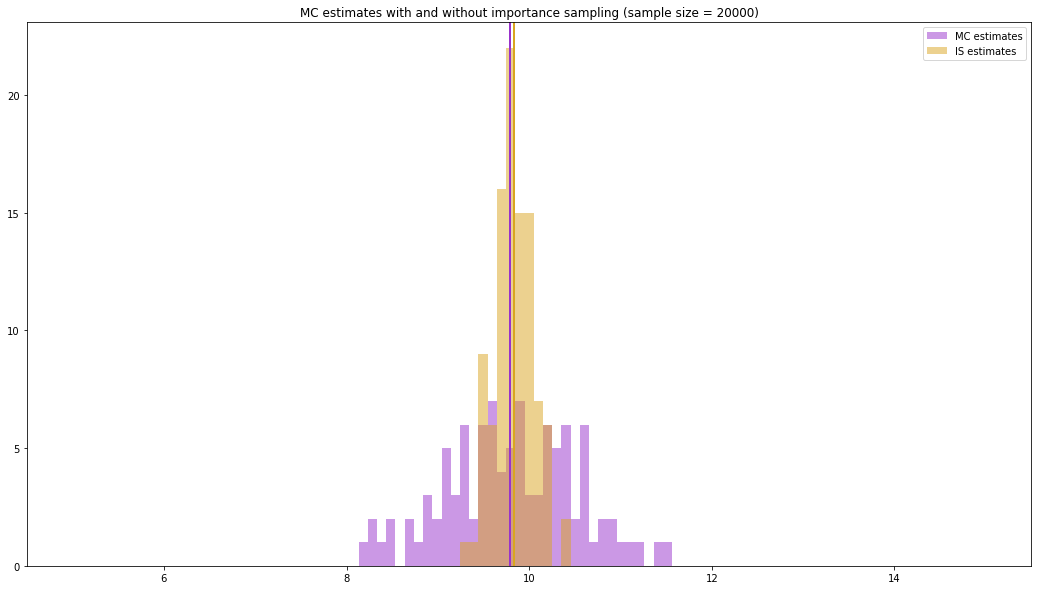

In [62]:
print("mean MC estimate:  ", np.around(np.mean(means_MC), 4))
print("mean IS estimate: ", np.around(np.mean(means_IS), 4))
 
bins = np.linspace(5.00, 15.00, 100)
 
plt.figure(figsize=(18, 10)) 
plt.hist(means_MC, bins, color="darkorchid", alpha=0.5, label="MC estimates")
plt.hist(means_IS, bins, color="goldenrod", alpha=0.5, label="IS estimates")
plt.axvline(np.mean(means_MC), color="darkorchid", linewidth=2)
plt.axvline(np.mean(means_IS), color="goldenrod", linewidth=2)
plt.title("MC estimates with and without importance sampling (sample size = 20000)")
plt.legend(loc="upper right")
plt.show()

mean MC estimate standard error:   0.7627
mean IS estimate standard error:  0.2033


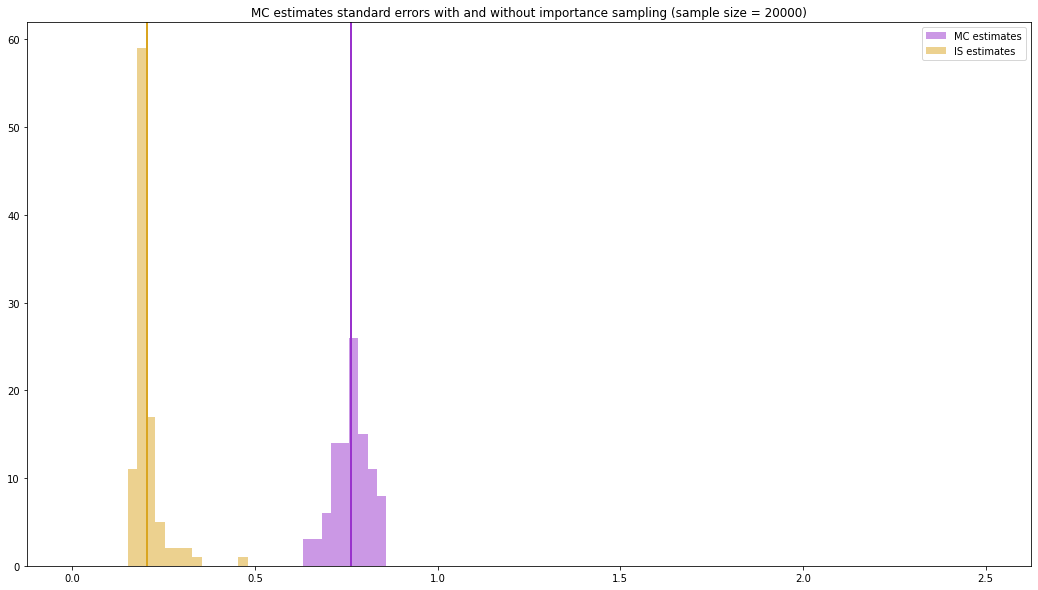

In [63]:
print("mean MC estimate standard error:  ", np.around(np.mean(stderr_MC), 4))
print("mean IS estimate standard error: ", np.around(np.mean(stderr_IS), 4))
 
bins = np.linspace(0.00, 2.50, 100)
 
plt.figure(figsize=(18, 10)) 
plt.hist(stderr_MC, bins, color="darkorchid", alpha=0.5, label="MC estimates")
plt.hist(stderr_IS, bins, color="goldenrod", alpha=0.5, label="IS estimates")
plt.axvline(np.mean(stderr_MC), color="darkorchid", linewidth=2)
plt.axvline(np.mean(stderr_IS), color="goldenrod", linewidth=2)
plt.title("MC estimates standard errors with and without importance sampling (sample size = 20000)")
plt.legend(loc="upper right")
plt.show()

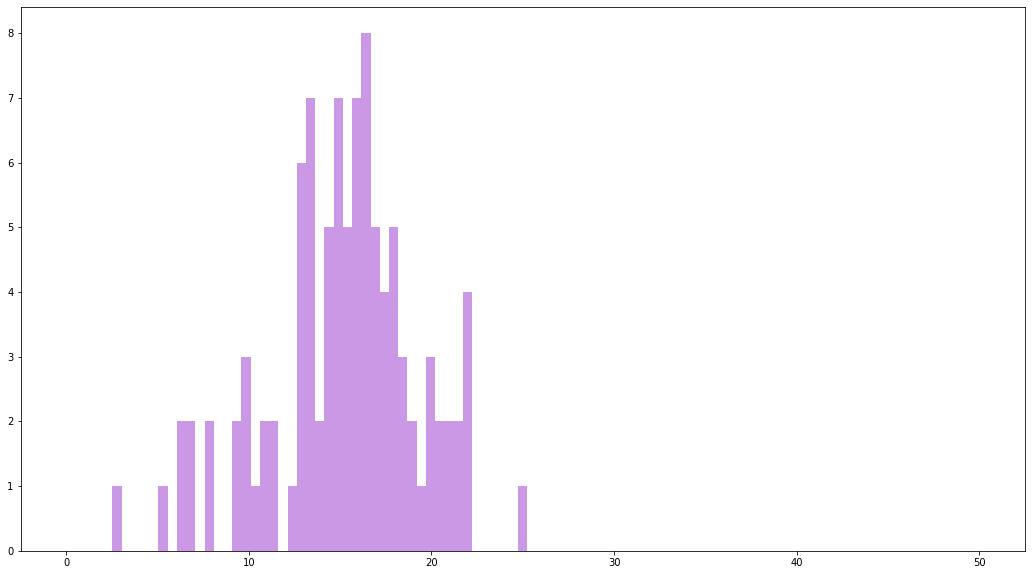

In [64]:
bins = np.linspace(0.00, 50.00, 100)
 
plt.figure(figsize=(18, 10)) 
plt.hist(varratio, bins, color="darkorchid", alpha=0.5)
plt.show()

In [65]:
data = {'mean MC': means_MC,
        'mean IS': means_IS,
        'stderr MC': stderr_MC,
        'stderr IS': stderr_IS, 
        'varratio': varratio}
 
df = pd.DataFrame(data, columns = ['mean MC','mean IS', 'stderr MC', 'stderr IS', 'varratio'])
df = df.sort_values(by=['varratio'])
 
print(df.tail(50))

      mean MC    mean IS  stderr MC  stderr IS   varratio
29   9.390660   9.503312   0.763306   0.194594  15.386487
85   9.185191  10.123295   0.830468   0.209650  15.691193
95  10.417519  10.019287   0.812441   0.204542  15.776709
50   8.886349   9.745810   0.708737   0.178361  15.789520
45   8.501616   9.736068   0.711803   0.178729  15.861013
91  10.159264   9.985974   0.779892   0.195698  15.881661
70  10.074681   9.784296   0.798165   0.199583  15.993307
1    9.592737   9.815927   0.781168   0.195210  16.013451
41   8.778517   9.816628   0.765012   0.189717  16.260150
7    9.510287   9.692482   0.715994   0.177541  16.263717
69   9.000713   9.938125   0.767638   0.190340  16.264910
17   9.628488   9.490688   0.750027   0.185263  16.389954
6   10.593658   9.708722   0.794964   0.196033  16.445051
31   9.944496   9.779675   0.779698   0.192196  16.457489
27  10.357671   9.962090   0.813096   0.199311  16.642612
12   9.888854   9.628847   0.747462   0.183219  16.643138
82   9.885608 

In [66]:
print(np.around(stderr_MC[0] / means_MC[0] * 100, 6))
print(np.around(stderr_IS[0] / means_IS[0] * 100, 6))

8.009106
4.67604


In [67]:
stderr_IS[25]

0.21604348975738485

In [68]:
N_reps = 25
N_sample = 100000
 
start_time = time.time()
 
means_MC = []
means_IS = []
 
stderr_MC = []
stderr_IS = []
 
varratio = []
 
for k in trange(N_reps):
# for k in progressbar(range(N_reps), "Computing: ", 60):
    outcomes_MC = []
    outcomes_IS = []
    
    # for i in trange(N_sample):
    # for i in progressbar(range(N_sample), "Computing: ", 60):
    for i in range(N_sample):
        
        M_random = np.concatenate((np.zeros((N_assets,1)), np.random.normal(0, np.sqrt(delta_t), (N_assets,N))), axis=1)
    
        ##########
    
        M_MC = np.cumsum(M_random, axis=1)
        M_MC = np.dot(np.transpose(sigma), M_MC)
 
        M_MC = np.diff(M_MC, axis=1)
        M_MC = M_MC + tilde_mu * delta_t
 
        M_MC = np.concatenate((np.zeros((N_assets,1)),M_MC), axis=1)
        M_MC = np.cumsum(M_MC, axis=1)
 
        M_MC = np.exp(M_MC)
        for j in range(N_assets):
            M_MC[j,:] = M_MC[j,:] * X_0[j]
        
        ot_MC = np.clip(np.sum(np.multiply(weights, np.sum(M_MC * delta_t, axis=1).reshape((N_assets,1)) / T)) - strike, 0, None)
        
        outcomes_MC = outcomes_MC + [np.exp(-r*T) * 100 * ot_MC]
 
        ##########
    
        M_0 = M_random + np.concatenate((np.zeros((N_assets,1)), np.transpose(learnedstrat[0:N,:]) * delta_t), axis=1)
    
        M_0 = np.cumsum(M_0, axis=1)
        M = np.dot(np.transpose(sigma), M_0)
 
        M = np.diff(M, axis=1)
        M = M + tilde_mu * delta_t
    
        M = np.concatenate((np.zeros((N_assets,1)), M), axis=1)
        M = np.cumsum(M, axis=1)
 
        M = np.exp(M)
        for j in range(N_assets):
            M[j,:] = M[j,:] * X_0[j]
        
        M_0 = np.diff(M_0, axis=1)
    
        adj1 = np.sum(np.sum(np.multiply(np.transpose(learnedstrat[0:N,:]), M_0), axis=1), axis=0)
        adj2 = np.sum(np.sum(np.multiply(np.transpose(learnedstrat[0:N,:]), np.transpose(learnedstrat[0:N,:])) * delta_t, axis=1), axis=0)
    
        ot_IS = np.clip(np.sum(np.multiply(weights, np.sum(M * delta_t, axis=1).reshape((N_assets,1)) / T)) - strike, 0, None)
        
        outcomes_IS = outcomes_IS + [np.exp(-r*T) * 100 * ot_IS * np.exp(-1 * adj1 + 0.5 * adj2)]
    
    means_MC = means_MC + [np.mean(outcomes_MC)]
    means_IS = means_IS + [np.mean(outcomes_IS)]
    
    stderr_MC = stderr_MC + [np.std(outcomes_MC) / np.sqrt(N_sample)]
    stderr_IS = stderr_IS + [np.std(outcomes_IS) / np.sqrt(N_sample)]
    
    varratio = varratio + [np.var(outcomes_MC) / np.var(outcomes_IS)]
    
    if (k+1) % 10 == 0:
        elapsed_time = time.time() - start_time
        print("elapsed time: ", time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))
    
elapsed_time = time.time() - start_time
print("total elapsed time: ", time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

  0%|          | 0/25 [00:00<?, ?it/s]

elapsed time:  00:35:41
elapsed time:  01:10:07
total elapsed time:  01:27:48


In [69]:
print("Mean (MC): ", np.around(np.mean(means_MC), 4))
print("Mean (IS): ", np.around(np.mean(means_IS), 4))
print("Standard error (MC): ", np.around(np.mean(stderr_MC), 4), " (", np.around(np.mean(stderr_MC) / np.mean(means_MC) * 100, 2), "% )")
print("Standard error (IS): ", np.around(np.mean(stderr_IS), 4), " (", np.around(np.mean(stderr_IS) / np.mean(means_IS) * 100, 2), "% )")
print("Variance ratio: ", np.around(np.mean(varratio)))

Mean (MC):  9.9536
Mean (IS):  9.8535
Standard error (MC):  0.3449  ( 3.46 % )
Standard error (IS):  0.0923  ( 0.94 % )
Variance ratio:  14.0


mean MC estimate:   9.9536
mean IS estimate:  9.8535


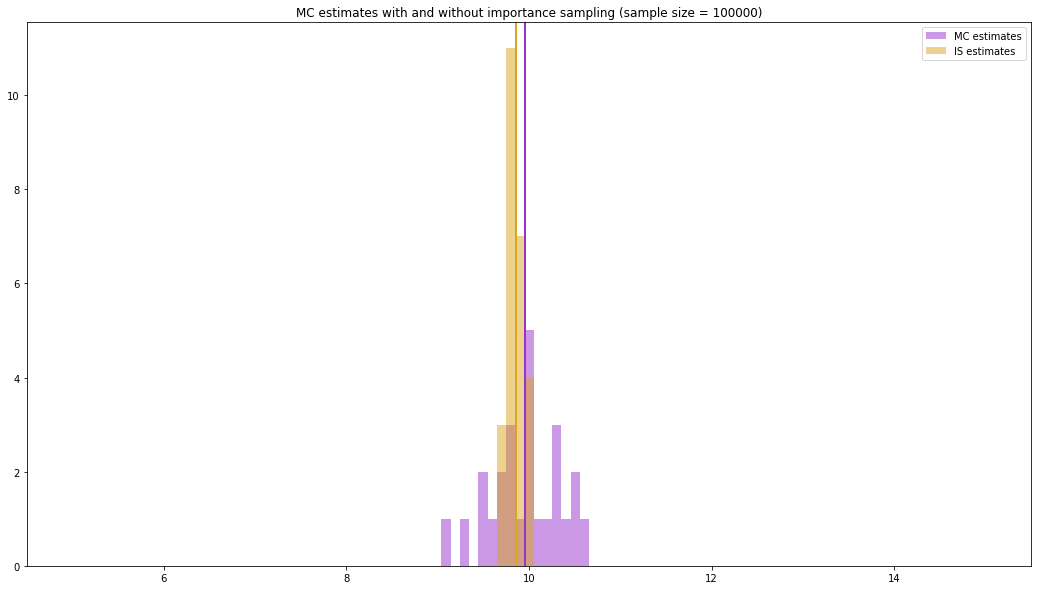

In [71]:
print("mean MC estimate:  ", np.around(np.mean(means_MC), 4))
print("mean IS estimate: ", np.around(np.mean(means_IS), 4))
 
bins = np.linspace(5.00, 15.00, 100)
 
plt.figure(figsize=(18, 10)) 
plt.hist(means_MC, bins, color="darkorchid", alpha=0.5, label="MC estimates")
plt.hist(means_IS, bins, color="goldenrod", alpha=0.5, label="IS estimates")
plt.axvline(np.mean(means_MC), color="darkorchid", linewidth=2)
plt.axvline(np.mean(means_IS), color="goldenrod", linewidth=2)
plt.title("MC estimates with and without importance sampling (sample size = 100000)")
plt.legend(loc="upper right")
plt.show()

mean MC estimate standard error:   0.3449
mean IS estimate standard error:  0.0923


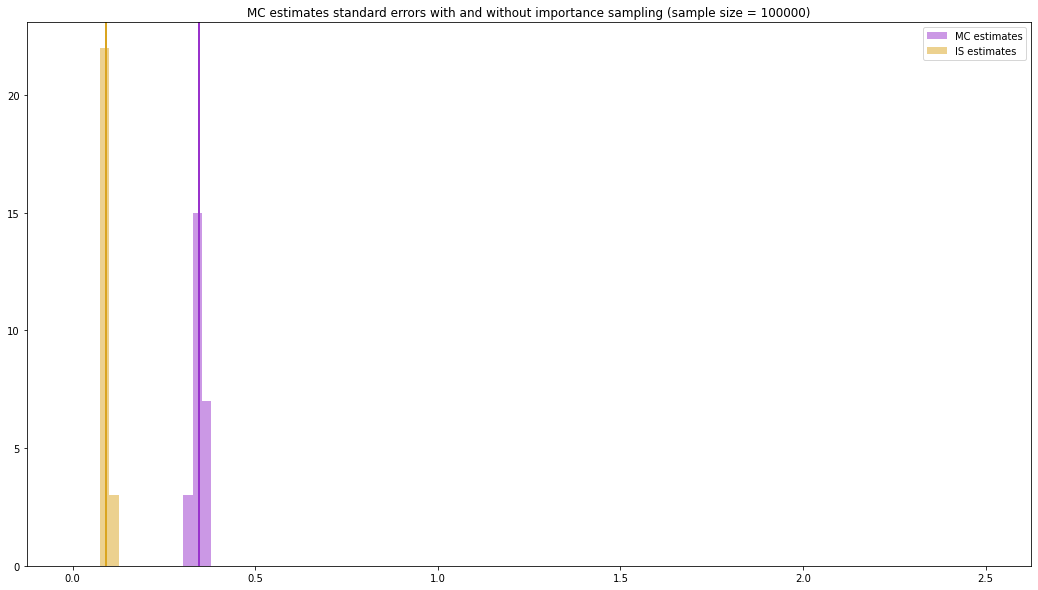

In [72]:
print("mean MC estimate standard error:  ", np.around(np.mean(stderr_MC), 4))
print("mean IS estimate standard error: ", np.around(np.mean(stderr_IS), 4))
 
bins = np.linspace(0.00, 2.50, 100)
 
plt.figure(figsize=(18, 10)) 
plt.hist(stderr_MC, bins, color="darkorchid", alpha=0.5, label="MC estimates")
plt.hist(stderr_IS, bins, color="goldenrod", alpha=0.5, label="IS estimates")
plt.axvline(np.mean(stderr_MC), color="darkorchid", linewidth=2)
plt.axvline(np.mean(stderr_IS), color="goldenrod", linewidth=2)
plt.title("MC estimates standard errors with and without importance sampling (sample size = 100000)")
plt.legend(loc="upper right")
plt.show()

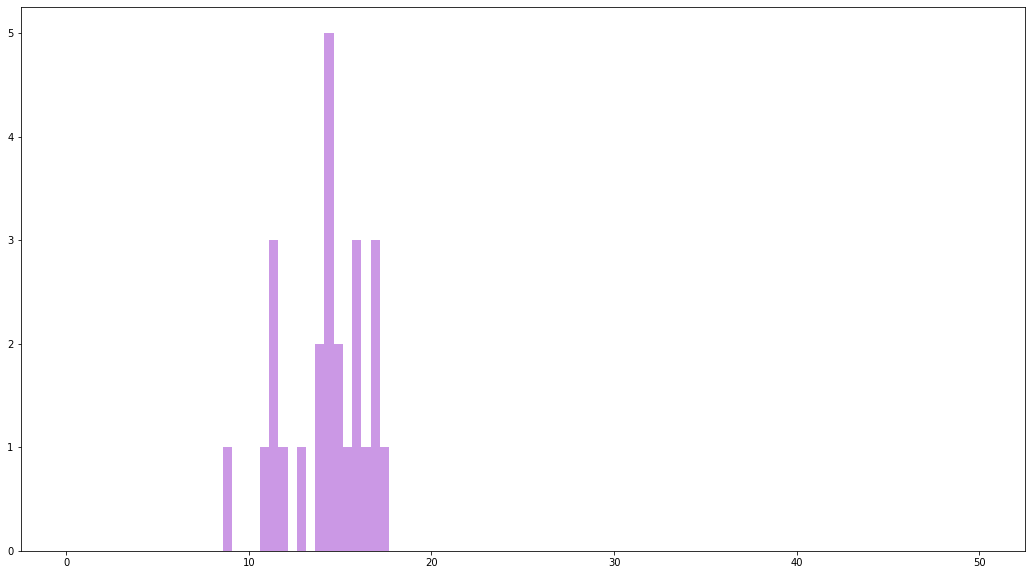

In [73]:
bins = np.linspace(0.00, 50.00, 100)
 
plt.figure(figsize=(18, 10)) 
plt.hist(varratio, bins, color="darkorchid", alpha=0.5)
plt.show()

In [74]:
data = {'mean MC': means_MC,
        'mean IS': means_IS,
        'stderr MC': stderr_MC,
        'stderr IS': stderr_IS, 
        'varratio': varratio}
 
df = pd.DataFrame(data, columns = ['mean MC','mean IS', 'stderr MC', 'stderr IS', 'varratio'])
df = df.sort_values(by=['varratio'])
 
print(df.tail(25))

      mean MC    mean IS  stderr MC  stderr IS   varratio
20   9.997384   9.962850   0.339809   0.113118   9.024090
2   10.096371   9.961785   0.351806   0.107219  10.766307
9    9.288893   9.906222   0.332755   0.099757  11.126628
3    9.517615  10.005289   0.332265   0.099284  11.199763
14  10.599496   9.992924   0.376104   0.110604  11.563037
21  10.325773   9.945253   0.341188   0.099895  11.665484
1    9.626335   9.813773   0.327665   0.091360  12.863138
8    9.966383   9.926634   0.345405   0.093166  13.744854
22   9.751056   9.880234   0.332706   0.088698  14.069872
12   9.732873   9.818462   0.327345   0.086852  14.205287
19   9.472588   9.780370   0.330896   0.087365  14.345165
24   9.076962   9.729519   0.316540   0.083401  14.404944
18   9.988396   9.771564   0.340769   0.089530  14.487222
11  10.281167   9.925722   0.360248   0.094598  14.502539
13   9.788398   9.813486   0.339558   0.088061  14.868192
6    9.820474   9.815666   0.340670   0.088139  14.939258
17  10.389604 

In [75]:
print(np.around(stderr_MC[0] / means_MC[0] * 100, 6))
print(np.around(stderr_IS[0] / means_IS[0] * 100, 6))

3.497032
0.880905


In [77]:
stderr_IS[0]

0.08625702665701375

In [78]:
N_reps = 1
N_sample = 1000000
 
start_time = time.time()
 
means_MC = []
means_IS = []
 
stderr_MC = []
stderr_IS = []
 
varratio = []
 
for k in trange(N_reps):
# for k in progressbar(range(N_reps), "Computing: ", 60):
    outcomes_MC = []
    outcomes_IS = []
    
    # for i in trange(N_sample):
    # for i in progressbar(range(N_sample), "Computing: ", 60):
    for i in trange(N_sample):
        
        M_random = np.concatenate((np.zeros((N_assets,1)), np.random.normal(0, np.sqrt(delta_t), (N_assets,N))), axis=1)
    
        ##########
    
        M_MC = np.cumsum(M_random, axis=1)
        M_MC = np.dot(np.transpose(sigma), M_MC)
 
        M_MC = np.diff(M_MC, axis=1)
        M_MC = M_MC + tilde_mu * delta_t
 
        M_MC = np.concatenate((np.zeros((N_assets,1)),M_MC), axis=1)
        M_MC = np.cumsum(M_MC, axis=1)
 
        M_MC = np.exp(M_MC)
        for j in range(N_assets):
            M_MC[j,:] = M_MC[j,:] * X_0[j]
        
        ot_MC = np.clip(np.sum(np.multiply(weights, np.sum(M_MC * delta_t, axis=1).reshape((N_assets,1)) / T)) - strike, 0, None)
        
        outcomes_MC = outcomes_MC + [np.exp(-r*T) * 100 * ot_MC]
 
        ##########
    
        M_0 = M_random + np.concatenate((np.zeros((N_assets,1)), np.transpose(learnedstrat[0:N,:]) * delta_t), axis=1)
    
        M_0 = np.cumsum(M_0, axis=1)
        M = np.dot(np.transpose(sigma), M_0)
 
        M = np.diff(M, axis=1)
        M = M + tilde_mu * delta_t
    
        M = np.concatenate((np.zeros((N_assets,1)), M), axis=1)
        M = np.cumsum(M, axis=1)
 
        M = np.exp(M)
        for j in range(N_assets):
            M[j,:] = M[j,:] * X_0[j]
        
        M_0 = np.diff(M_0, axis=1)
    
        adj1 = np.sum(np.sum(np.multiply(np.transpose(learnedstrat[0:N,:]), M_0), axis=1), axis=0)
        adj2 = np.sum(np.sum(np.multiply(np.transpose(learnedstrat[0:N,:]), np.transpose(learnedstrat[0:N,:])) * delta_t, axis=1), axis=0)
    
        ot_IS = np.clip(np.sum(np.multiply(weights, np.sum(M * delta_t, axis=1).reshape((N_assets,1)) / T)) - strike, 0, None)
        
        outcomes_IS = outcomes_IS + [np.exp(-r*T) * 100 * ot_IS * np.exp(-1 * adj1 + 0.5 * adj2)]
    
    means_MC = means_MC + [np.mean(outcomes_MC)]
    means_IS = means_IS + [np.mean(outcomes_IS)]
    
    stderr_MC = stderr_MC + [np.std(outcomes_MC) / np.sqrt(N_sample)]
    stderr_IS = stderr_IS + [np.std(outcomes_IS) / np.sqrt(N_sample)]
    
    varratio = varratio + [np.var(outcomes_MC) / np.var(outcomes_IS)]
    
    if (k+1) % 10 == 0:
        elapsed_time = time.time() - start_time
        print("elapsed time: ", time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))
    
elapsed_time = time.time() - start_time
print("total elapsed time: ", time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

KeyboardInterrupt: ignored